In [75]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['figure.figsize'] = (9, 7)


## Loading and ploting the image

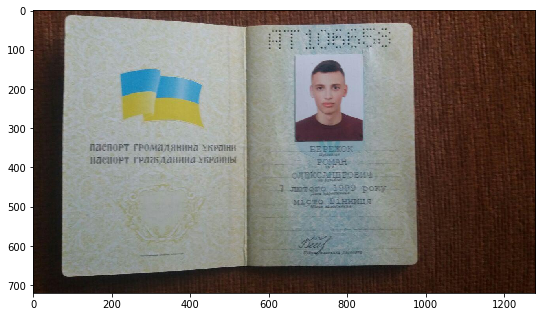

In [217]:
IMG_PATH = 'images/7.jpg'
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_orig = img.copy()
plt.imshow(img)

## Edge detection

In [218]:
MIN_VAL = 200
MAX_VAL = 250

def detect_edges(img, min_val=MIN_VAL, max_val=MAX_VAL):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply filter, threshold and blur
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    img = cv2.medianBlur(img, 5)

    # Apply Canny edge detector
    img = cv2.Canny(img, min_val, max_val)
    
    # Apply morph transformation (img => erosion => dilation)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((5, 11)))
    
    return img

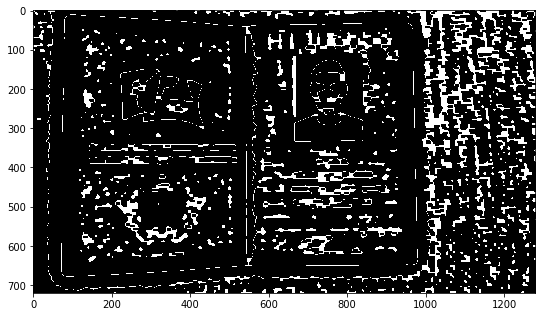

In [219]:
edges_img = detect_edges(img)
plt.imshow(edges_img, cmap='gray')

## Finding contours

In [220]:
def find_contours(edges_img):
    # Get contours
    contours, hierarchy = cv2.findContours(edges_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the biggest rectangle
    height, width = edges_img.shape
    MIN_CONTOUR_AREA = width * height * 0.5

    max_area = MIN_CONTOUR_AREA
    max_contour = np.array([[0, 0],
                           [0, height],
                           [width, height],
                           [width, 0]])

    for contour in contours:
        perimeter = cv2.arcLength(contour, closed=True)
        approx = cv2.approxPolyDP(contour, 0.03 * perimeter, closed=True)

        if(len(approx) == 4 and max_area < cv2.contourArea(approx)):
            max_area = cv2.contourArea(approx)
            max_contour = approx[:, 0]
    
    return max_contour

Contours:
 [[ 83  17]
 [ 77 675]
 [976 643]
 [960  36]]


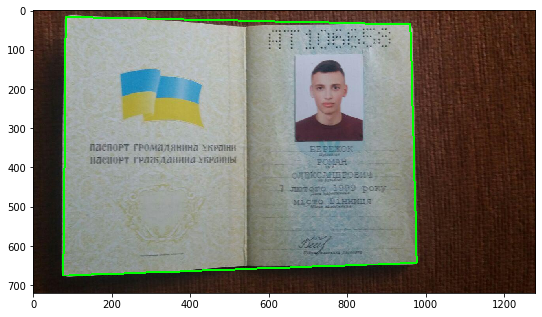

In [221]:
contours = find_contours(edges_img)
print('Contours:\n', contours)
plt.imshow(cv2.drawContours(img_orig, [contours], -1, (0, 255, 0), 3))

## Transform perspective